In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
import warnings  
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import pandas as pd
import pickle

In [2]:
df=pd.read_csv('./data/CustomerData_LeadGenerator.csv', index_col='fakeID')

## Data Preperation

From our Exploratory Data Analysis - see [EDA-Customer-lead-generator.ipynb](EDA-Customer-lead-generator.ipynb) - we know that we need to coerce the column **q_OpeningHours** and drop the failing row(s). We also need to drop the highly correlated columns.

In [3]:
df['q_OpeningHours'] = pd.to_numeric(df['q_OpeningHours'], errors='coerce')
rows_before = df.shape[0]
df.dropna(inplace=True)
print('dropped {} row(s)'.format(rows_before - df.shape[0]))

dropped 1 row(s)


In [4]:
highly_correlated_cols = ['q_2017 HHs: 5th Quintile (68.759 and above)', 
                          'q_2017 Total Population', 
                          'q_2017 Pop 15+/Edu: University, Fachhochschule', 
                          'q_2017 Personal Care: Per Capita', 
                          'q_2017 Personal Effects: Per Capita']
df = df.drop(highly_correlated_cols, axis=1)

Let's rename some of the columns and identify the numeric columns for later.

In [5]:
df = df.rename(columns={"b_gekauft_gesamt": "converted", "b_in_kontakt_gewesen": "contacted"})

In [6]:
numeric_cols = ['q_OpeningDays',
                'q_OpeningHours',
                'q_2017 Average Household Size',
                'q_2017 Total Households', 
                'q_5th Quint by Total HH', 
                'q_2017 Purchasing Power: Per Capita', 
                'q_Uni by Total Pop', 
                'q_2017 Medical Products: Per Capita']

## Binary Classification
The problem we are trying to solve is really a binary classification problem. We have a target feature we are looking at - **converted** and it can take only 2 values - 0 or 1.

In [7]:
target_col = ['converted']

In [8]:
# split the data by the target column
df_x = df.drop(target_col, axis=1)
df_y = df[target_col]

## Train and test split
We will split the data into two parts: one part we will use for **training** and the other part we will use for **testing**. We will use an 80/20 split, i.e. 80% of the data will be used for **training** and 20% of the data will be used for **testing**.

In [9]:
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, train_size=0.8, test_size=0.2, random_state=42)

### Standardize the numeric data
We standardize the numeric data to make sure that the values are in the same range. This is done after the train/test split as we will calculate the standardization parameters using the training data. We assume that the testing is from the same population so we don't include it in this initial calculation. This also means that we can test and evaluate whether our model can generalize well to new, unseen data points.

In [10]:
scaler = StandardScaler()
scaler = scaler.fit(x_train[numeric_cols])

In [11]:
x_train[numeric_cols] = scaler.transform(x_train[numeric_cols])

If our standardization has worked correctly we should see that the statistics for the numeric columns have an approximate **std** of 1.0 and a **mean** of 0.0

In [12]:
x_train[numeric_cols].describe()

,q_OpeningDays,q_OpeningHours,q_2017 Average Household Size,q_2017 Total Households,q_5th Quint by Total HH,q_2017 Purchasing Power: Per Capita,q_Uni by Total Pop,q_2017 Medical Products: Per Capita
count,3.017000e+03,3.017000e+03,3.017000e+03,3.017000e+03,3.017000e+03,3.017000e+03,3.017000e+03,3.017000e+03
mean,4.945773e-17,1.413078e-16,-8.101647e-16,-2.781997e-17,-7.771929e-17,7.418660e-16,2.361018e-16,8.690430e-16
std,1.000166e+00,1.000166e+00,1.000166e+00,1.000166e+00,1.000166e+00,1.000166e+00,1.000166e+00,1.000166e+00
min,-1.548350e+00,-1.417470e+00,-1.579254e+00,-9.388964e-01,-3.883756e+00,-3.511241e+00,-1.857271e+00,-5.008505e+00
25%,-1.548350e+00,-1.417470e+00,-9.288839e-01,-7.604606e-01,-5.215450e-01,-4.593578e-01,-9.763105e-01,-3.626544e-01
50%,3.765998e-01,1.886436e-01,-2.785143e-01,-5.682320e-01,-7.667956e-02,3.952347e-01,-5.252173e-03,-5.050011e-02
75%,8.578372e-01,7.240146e-01,1.022225e+00,1.398526e+00,6.570877e-01,5.788550e-01,1.108597e+00,5.097767e-01
max,1.820312e+00,3.783278e+00,4.274073e+00,1.762645e+00,2.881636e+00,2.481521e+00,1.743301e+00,3.272920e+00


Success! Now we can standardize the testing data using the scaling from the training data.

In [13]:
x_test[numeric_cols] = scaler.transform(x_test[numeric_cols])

## Model type
Since this is a binary classification problem we will use a [Random Forest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) provided by the **sklearn** package.

In [14]:
# Create the Random Forest Classifier model
num_estimators = 100
min_samples = 4
model = RandomForestClassifier(n_estimators=num_estimators, min_samples_split=min_samples)

## Train the model
We can now train the model using the training data.

In [15]:
model.fit(x_train, y_train.values.ravel())

RandomForestClassifier(min_samples_split=4)

### Save the model
We should save the model so we can load it later.

In [16]:
filename = 'final_model.pkl'
pickle.dump(model, open(filename, 'wb'))

In [17]:
def calc_cm_stats(cm):
    """Calculate stats using the provided confusion matrix
    
    Args:
        cm: confusion matrix
    Returns:
        accuracy, specificity, sensitivity
    """
    TP = cm[1,1] # true positive 
    TN = cm[0,0] # true negatives
    FP = cm[0,1] # false positives
    FN = cm[1,0] # false negatives
    accuracy = (TN+TP)/sum(sum(cm))
    specificity = TN/(TN+FP)
    sensitivity = TP/float(TP+FN)
    return accuracy, specificity, sensitivity

## Feature Importance
Let's discover the feature importances of this trained model.

In [18]:
feat_labels = x_train.columns
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]  # show them in decreasing order of importance
num_features = x_train.shape[1]

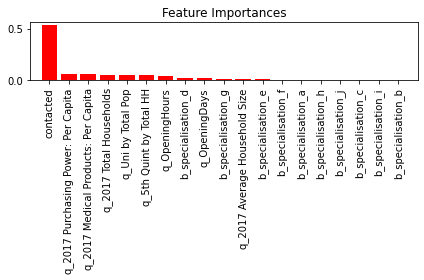

In [19]:
plt.title('Feature Importances')
plt.bar(range(num_features), importances[indices], color='r', align='center')
plt.xticks(range(num_features), feat_labels[indices], rotation=90)
plt.xlim([-1, num_features])
plt.tight_layout()
plt.show()

We had already observed with our EDA that **contacted** was an important feature. Here we can see it's clearly the most important one.

## Testing the trained model
Having trained our model we will now use it to make predictions with the test data.

In [20]:
y_test_pred = model.predict(x_test)

In [21]:
# get the predicted probabilities of it being a converted sale
y_test_prob = model.predict_proba(x_test)[:, 1]

In [22]:
accuracy = metrics.accuracy_score(y_test, y_test_pred)
auc_score = metrics.roc_auc_score(y_test, y_test_pred)

print(f'accuracy: {accuracy:.2f}')
print(f'area under curve (AUC): {auc_score:.2f}')

accuracy: 0.99
area under curve (AUC): 0.79


## Plotting ROC curve

In [23]:
def draw_roc(actual, probs):
    fpr, tpr, thresholds = metrics.roc_curve(actual, probs, drop_intermediate=False)
    auc_score = metrics.roc_auc_score(actual, probs)
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.show()

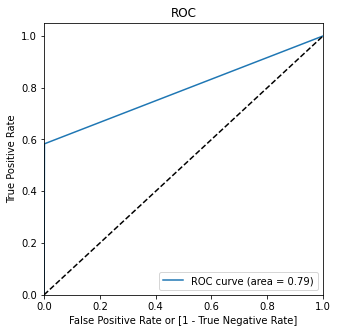

In [24]:
draw_roc(y_test, y_test_pred)

The ROC curve should be close to 1. We are getting a value of 0.79 on data that we haven't seen before. This is still a good value. This means that there is a 79% chance that the model will be able to distinguish between those that can produce **converted** sales and those that can't. This could be improved by having more training data that includes more converted sales.

## Testing Observation
After doing our testing we have found the following statistics:
* Accuracy: 0.99
* AUC: 0.71

## Confusion Matrix

The confusion matrix is another way of showing predictions of **True Negative**, **False Positive**, **False Negative** and **True Positive** by the model.

In [25]:
# Confusion matrix 
confusion = metrics.confusion_matrix(y_test, y_test_pred)

[[742   1]
 [  5   7]]


<AxesSubplot:>

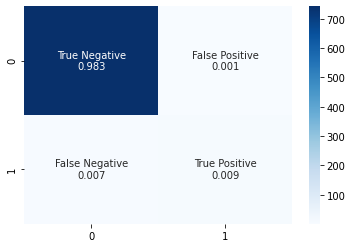

In [26]:
group_names = ['True Negative','False Positive','False Negative','True Positive']
group_percentages = [f'{value:.3f}' for value in confusion.flatten()/np.sum(confusion)]
labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(confusion, annot=labels, fmt='', cmap='Blues')

It makes sense that we are 98.1% accurate in predicting a true negative since the bulk of our data - 98.5% - is negative (i.e.
most of the customers did not lead to a completed sale).

## Final Observations
Our final observations are that the Model seems to predict the Conversion Rate quite well and can be used to make good contacts based on it. The predictions of conversions from this model are 79% sure. It also worth noting that the model could be further improved by providing more data from converted sales.